# Exercise 1

Conceptual: Why does a static preference dataset become insufficient as a policy improves? Explain using an example: initial model outputs are poor, so human preferences cover only easy mistakes; once the model stops making those, the old data is less relevant. How does online DPO address this?

## Solution


A static dataset is **tied to the behavior of the policy that generated it**. As the policy improves, two things happen:

1. **The dataset stops matching the policy’s error profile (distribution shift).**
   Early on, the model makes *obvious* mistakes, so humans mostly compare **bad vs. decent** outputs. After training, the policy rarely produces the “bad” outputs anymore, so those comparisons are no longer representative of what the policy currently does.

2. **The comparisons become weak training signal (saturation).**
   DPO updates are driven by the *margin* between preferred and rejected:
   $$
   \Delta = \big(\log \pi(y_w|x)-\log \pi(y_l|x)\big) - \big(\log \pi_{\text{ref}}(y_w|x)-\log \pi_{\text{ref}}(y_l|x)\big).
   $$
   If the improved policy already strongly prefers (y_w) over (y_l) on the old dataset, (\Delta) is large, the logistic loss saturates, and gradients become small. So the old dataset gives diminishing returns.


Online DPO fixes the mismatch by making the data **on-policy (or near on-policy)** each iteration:

* **Generate candidates from the current policy** (often with some exploration to get diversity).

* **Collect fresh preferences** on *these* candidates.

* **Update with DPO on the new comparisons**, typically with **anchoring/regularization** to prevent drift.



# Exercise 2

Coding: Implement a simple simulation of OFS-DPO. Use two copies of a model (e.g., two sets of parameters representing fast and slow). At each iteration: have the fast model generate an output for a query, label its quality with a simulated metric (e.g., a known reward function or a proxy judge), update fast model via DPO loss, and occasionally copy fast weights to slow. Monitor a metric (like the difference between fast and slow policy outputs or rewards over time) to verify that fast adapts quickly and slow provides a stabilizing anchor.

## Solution

### OFS-DPO (toy) simulation

Two policies:
- **fast**: updated online from preferences
- **slow**: lags behind and stabilizes (copied from fast every `sync_every` steps)

We’ll track **average reward** and **fast–slow divergence** to see fast adapt quickly while slow provides an anchor.


In [1]:
import numpy as np

# Reproducible toy environment
rng = np.random.default_rng(0)

n_queries = 8
n_actions = 6
d = 12

phi = rng.normal(size=(n_queries, n_actions, d))
w_true = rng.normal(size=d)
reward = phi @ w_true
reward = reward / np.std(reward)


def softmax(z):
    z = z - z.max()
    e = np.exp(z)
    return e / e.sum()


def probs(theta, x):
    return softmax(phi[x] @ theta)


def expected_reward(theta):
    return float(np.mean([probs(theta, x) @ reward[x] for x in range(n_queries)]))


def avg_kl(theta_p, theta_q, eps=1e-12):
    kls = []
    for x in range(n_queries):
        p = np.clip(probs(theta_p, x), eps, 1.0)
        q = np.clip(probs(theta_q, x), eps, 1.0)
        kls.append(np.sum(p * (np.log(p) - np.log(q))))
    return float(np.mean(kls))


def sample_two(theta, x):
    p = probs(theta, x)
    y1, y2 = rng.choice(n_actions, size=2, replace=False, p=p)
    return int(y1), int(y2)

final  r_fast=1.450  r_slow=1.450  KL(f||s)=0.000  ||θf-θs||=0.000


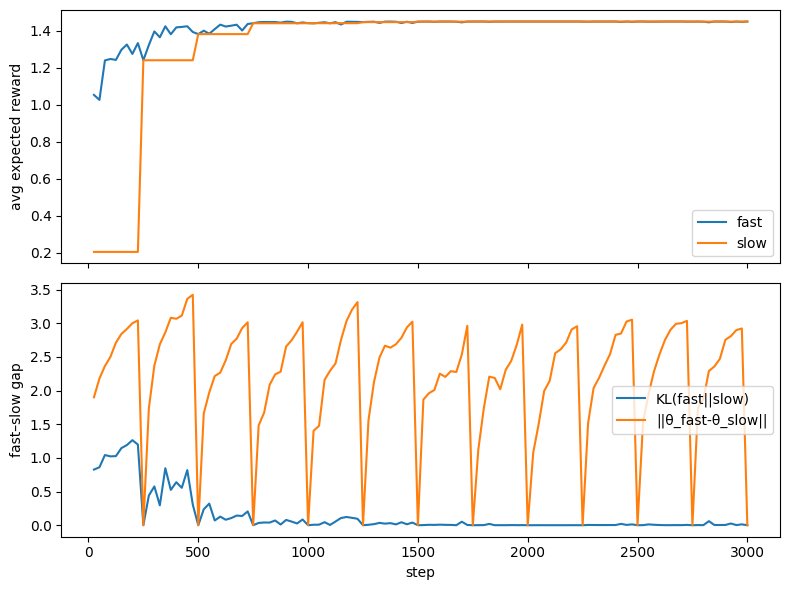

In [2]:
# OFS-DPO loop: fast updates every step; slow syncs periodically
beta = 2.0
lr = 0.1
steps = 3000
sync_every = 250
log_every = 25
noise_std = 0.15  # proxy judge noise

theta_fast = np.zeros(d)
theta_slow = theta_fast.copy()

logs = {"step": [], "r_fast": [], "r_slow": [], "kl_fs": [], "theta_gap": []}

for t in range(1, steps + 1):
    x = int(rng.integers(n_queries))

    # fast generates two candidates for the same query
    y1, y2 = sample_two(theta_fast, x)

    # simulated preference judge
    r1 = float(reward[x, y1] + rng.normal(scale=noise_std))
    r2 = float(reward[x, y2] + rng.normal(scale=noise_std))
    y_w, y_l = (y1, y2) if r1 >= r2 else (y2, y1)

    # DPO-style anchored update (reference = slow)
    dphi = phi[x, y_w] - phi[x, y_l]
    m = float(dphi @ (theta_fast - theta_slow))
    bm = np.clip(beta * m, -50, 50)
    w = 1.0 / (1.0 + np.exp(bm))  # sigmoid(-beta*m)
    theta_fast += lr * beta * w * dphi

    # occasional slow sync
    if t % sync_every == 0:
        theta_slow = theta_fast.copy()

    if t % log_every == 0:
        logs["step"].append(t)
        logs["r_fast"].append(expected_reward(theta_fast))
        logs["r_slow"].append(expected_reward(theta_slow))
        logs["kl_fs"].append(avg_kl(theta_fast, theta_slow))
        logs["theta_gap"].append(float(np.linalg.norm(theta_fast - theta_slow)))

print(
    f"final  r_fast={logs['r_fast'][-1]:.3f}  r_slow={logs['r_slow'][-1]:.3f}  "
    f"KL(f||s)={logs['kl_fs'][-1]:.3f}  ||θf-θs||={logs['theta_gap'][-1]:.3f}"
)

try:
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    ax[0].plot(logs["step"], logs["r_fast"], label="fast")
    ax[0].plot(logs["step"], logs["r_slow"], label="slow")
    ax[0].set_ylabel("avg expected reward")
    ax[0].legend()

    ax[1].plot(logs["step"], logs["kl_fs"], label="KL(fast||slow)")
    ax[1].plot(logs["step"], logs["theta_gap"], label="||θ_fast-θ_slow||")
    ax[1].set_xlabel("step")
    ax[1].set_ylabel("fast–slow gap")
    ax[1].legend()

    plt.tight_layout()
    plt.show()
except Exception as e:
    print("plot skipped:", type(e).__name__, str(e))


# Exercise 3

Discussion: The fast-slow approach mimics having an exploitative agent and a conservative baseline. In a production system like Sqwish, how might we implement this practically? (Hint: The “fast” could be a live updated prompt policy, and the “slow” could be a periodically retrained baseline that prevents the prompt strategy from drifting too far and causing bad experiences.) Propose a mechanism for deciding when to sync the slow model with the fast one (e.g., based on performance plateau or time interval).

## Solution


### Practical fast/slow implementation (production)

- **Fast (online, gradient-free policy layer)**
  - Treat **fast** as a live-updated *policy artifact* (e.g., prompt template).
  - Update it continuously from product signals (thumbs up/down, completions, revenue, etc.) using **gradient-free** methods (contextual bandits, Bayesian optimization).
  - Wrap it in **guardrails** (policy constraints, hard limits, monitoring).

- **Evaluate fast vs. slow using two feedback channels**
  - **Outcome metrics**: conversion/retention/revenue, task success, latency/cost, complaints.
  - **Preference data**: thumbs + pairwise comparisons.
    - Show **A = fast** vs **B = slow**.
  - **Experiment design**: continuous A/B, with minimum sample sizes + statistical significance, plus segment checks (new vs power users, languages, affluent vs thrifty).

- **Promotion criteria (fast → candidate slow refresh)**
  - **Wins primary KPI(s)** with statistical confidence.
  - **Not worse on key segments** / worst-case slices.
  - **Passes safety**: automated checks + human review on sampled traffic.
  - **Bounded drift**: fast stays within a defined divergence from slow.

- **Sync (train a new slow from fast on high-quality labeled data)**
  - Build a *high-quality* training set from production traffic:
    - **Thumbs-up / explicit positive feedback**.
    - **Outcome wins**: sessions linked to success (e.g., good revenue/conversion/retention, high task success, low complaint rates).
    - **Audited answers**: human-reviewed samples.
  - Convert that into preference/distillation data:
    - **Preference pairs for DPO**: for the same context `x`, compare `y_fast` vs `y_slow` (or other candidates) and keep pairs where `y_fast` is preferred.
    - **Format**: `(x, y_fast, y_slow)` plus any additional trusted human-labeled pairs.
  - Train the **new slow** using **both**:
    - **DPO** on the preference pairs (so slow learns *what to prefer*).
    - **Logprob (logit) distillation from fast**: train slow to match fast’s next-token logprobs.
  - Stabilize the update to avoid regressions:
    - **Replay** older preference data / critical behaviors to avoif forgetting.
    - **KL regularization** to the previous slow (or a reference model) to bound drift.

- **Release loop (how slow gets updated safely)**
  1. **Canary rollout** the new slow (**slow+1**) to a small slice of traffic.
  2. **Monitor KPIs**: outcome KPIs, preference win-rate (head-to-head vs the old slow), and safety incidents—broken down by key segments and high-risk slices.
  3. **Promote or rollback**: if it holds, make **slow+1** the new slow and reset fast’s baseline to it; otherwise roll back and keep iterating.


# Exercise 4

Discussion (Context vs. Weight Adaptation): The fast-slow paradigm updates model weights online. An alternative is updating contexts while keeping weights frozen: ACE (Day 10) does exactly this with evolving playbooks. Compare: weight-based (changes behavior fundamentally, requires gradients, risk of forgetting) vs. context-based (faster, interpretable, limited by context window, no forgetting). When might you prefer each? Consider: (1) dramatic domain shifts, (2) incorporating a single new policy, (3) regulated industries requiring auditability.

## Solution

In the Sqwish context, fast context updates are the safest and fastest way to adapt to live feedback.

Let's analyze these three scenarios:

- **A single new policy or rule**: Prefer fast context updates so the policy is explicit, versioned, and reversible. Distill into weights only if it becomes core behavior.
- **Regulated industries / auditability**: Prefer fast context updates for traceability, such as change logs, policy text, and approvals. Weight updates are less auditable and can introduce tricky second- and third-order effects, so they require stricter governance, replay, and safety reviews.
- **Out-of-distribution traffic**: Prefer slow weight updates when traffic moves into new domains, for example private enterprise data or novel task types, where the base model underperforms. Use fast context updates as a temporary bridge while collecting data for a stable retrain.